In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns

In [27]:
BATCH_SIZE = 32
INSTANCE_TYPE = "g5_xlarge"
INFERENCE_TPUT_MEAN = 23.04

Restart from checkpoint


In [ ]:
# Preprocessing for [restart from ckpt] experiment

df_before = pd.read_csv("results/restart_before_ckpt.csv")
df_after = pd.read_csv("results/restart_after_ckpt.csv")

global_start_time = 5829.961246506
records = []
df = pd.concat([df_before, df_after])

for idx, row in df.iterrows():
    if idx % 2 == 0:
        finish_time = row["content"]
    else:
        num_rows_completed = row["content"]
        records.append((finish_time, num_rows_completed))
df_agg = pd.DataFrame(records, columns=["time", "num_rows"])
df_agg["time_from_start"] = df_agg["time"] - global_start_time
df_agg["number_of_rows_finished"] = df_agg["num_rows"].cumsum()
print(
    "Throughput:", df_agg.iloc[-1]["number_of_rows_finished"] / df_agg.iloc[-1]["time_from_start"]
)

df_agg["time_from_start"] = pd.to_timedelta(df_agg["time_from_start"], unit="s")
df_agg.set_index("time_from_start", inplace=True)
df_agg["tput"] = df_agg["number_of_rows_finished"].diff() / df_agg.index.total_seconds().diff()
df_agg["tput"] = df_agg["tput"].fillna(0)

restart = df_agg["tput"].resample("60s").mean().fillna(0)
restart = restart.rolling(2).mean().fillna(0)

restart.index.total_minutes = restart.index.total_seconds() / 60

Throughput: 16.281286754484466


GPU only, GPU + CPU, GPU + CPU with failure


In [15]:
# df_{s3 or local}_{number of cpu nodes}_{number of gpu nodes}

df_s3_0_1 = pd.read_csv("results/[1x] g5.xlarge/video_inference_s3_g5_xlarge_batch_32.csv")
df_s3_1_1 = pd.read_csv(
    "results/[1x] g5.xlarge + [1x] m7i.2xlarge/video_inference_s3_g5_xlarge_batch_32.csv"
)
df_s3_1_1_wf = pd.read_csv(
    "results/_FAULT [1x] g5.xlarge + [1x] m7i.2xlarge/video_inference_s3_g5_xlarge_batch_32.csv"
)

In [25]:
def process(data, resample="60s"):
    data = data.copy()
    data["time_from_start"] = pd.to_timedelta(data["time_from_start"], unit="s")
    data.set_index("time_from_start", inplace=True)
    data["tput"] = data["number_of_rows_finished"].diff() / data.index.total_seconds().diff()
    data["tput"] = data["tput"].fillna(0)
    avg_tput = np.mean(data["tput"])
    tput_resampled = data["tput"].resample(resample).mean().bfill()
    idx = [(item.total_seconds() / 60) for item in tput_resampled.index]
    return idx, tput_resampled.values, avg_tput

In [26]:
idx_s3_0_1, values_s3_0_1, _ = process(df_s3_0_1)
idx_s3_1_1, values_s3_1_1, _ = process(df_s3_1_1)
idx_s3_1_1_wf, values_s3_1_1_wf, _ = process(df_s3_1_1_wf)

avg_s3_0_1 = df_s3_0_1.iloc[-1]["number_of_rows_finished"] / df_s3_0_1.iloc[-1]["time_from_start"]
avg_s3_1_1 = df_s3_1_1.iloc[-1]["number_of_rows_finished"] / df_s3_1_1.iloc[-1]["time_from_start"]
avg_s3_1_1_wf = (
    df_s3_1_1_wf.iloc[-1]["number_of_rows_finished"] / df_s3_1_1_wf.iloc[-1]["time_from_start"]
)

avg_s3_0_1, avg_s3_1_1, avg_s3_1_1_wf

(np.float64(6.188258389698372),
 np.float64(21.715949558226573),
 np.float64(18.62964358322438))

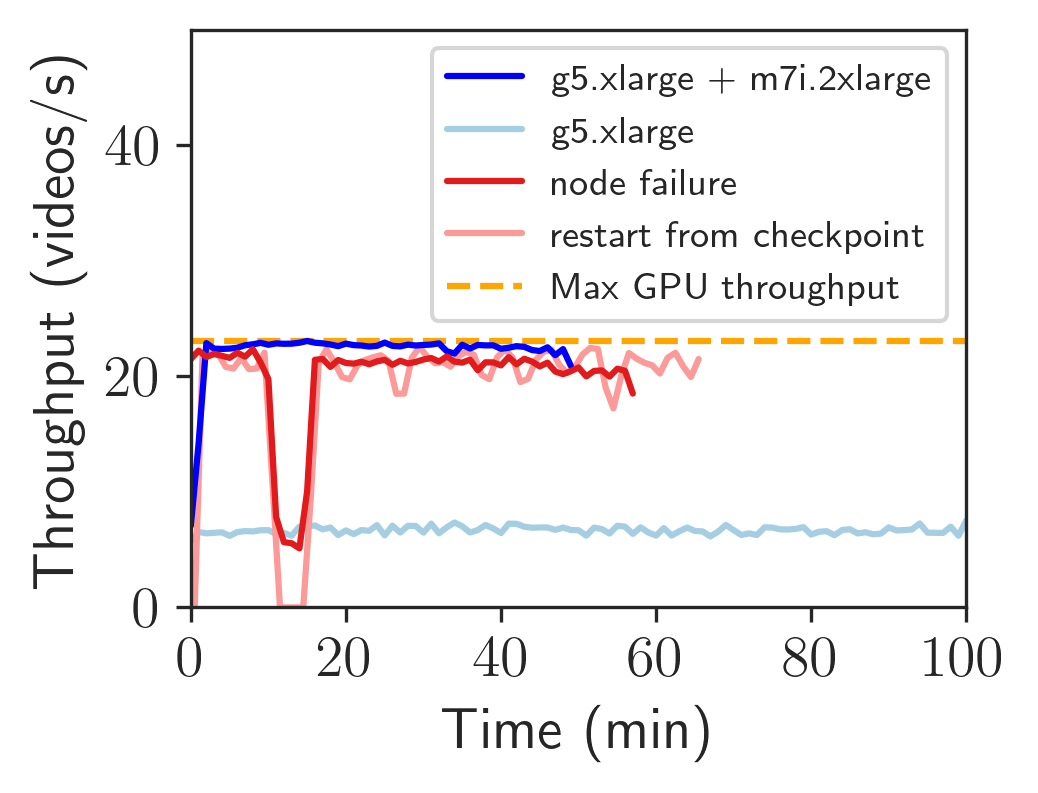

In [28]:
FIGRATIO = 3 / 4
FIGWIDTH = 3.335  # inches
FIGHEIGHT = FIGWIDTH * FIGRATIO
FIGSIZE = (FIGWIDTH, FIGHEIGHT)
BIG_SIZE = 14

COLORS = sns.color_palette("Paired")
sns.set_style("ticks")
sns.set_palette(COLORS)

plt.rcParams.update(
    {
        "figure.figsize": FIGSIZE,
        "figure.dpi": 300,
        "text.usetex": True,
    }
)
plt.rc("font", size=BIG_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIG_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIG_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=BIG_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=BIG_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=BIG_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIG_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()
ax.axhline(y=INFERENCE_TPUT_MEAN, color="orange", linestyle="--", label="Max GPU throughput")
ax.plot(idx_s3_0_1, values_s3_0_1, label="g5.xlarge", color=COLORS[0])
ax.plot(
    restart.index.total_seconds() / 60,
    restart.values,
    label="restart from checkpoint",
    color=COLORS[4],
)

ax.plot(idx_s3_1_1, values_s3_1_1, label="g5.xlarge + m7i.2xlarge", color="blue")
ax.plot(idx_s3_1_1_wf, values_s3_1_1_wf, label="node failure", color=COLORS[5])

plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

plt.xlabel("Time (min)")
plt.ylabel("Throughput (videos/s)")
plt.xlim(0, 100)
plt.ylim(0, 50)
handles, labels = plt.gca().get_legend_handles_labels()

# Reorder the legend
order = [3, 1, 4, 2, 0]
ordered_handles = [handles[i] for i in order]
ordered_labels = [labels[i] for i in order]
plt.legend(ordered_handles, ordered_labels, fontsize=9)

# plt.savefig("video-tput.pdf", bbox_inches='tight')